# 1. Basic workflow


This vignette shows the basic workflow of Via and how to access the different visualizations after running the computations. The dataset is a toy multifurcation.
We start by importing modules. 
the examples import is only required if running the function main_Toy() which wraps the workflow demonstrated below

In [1]:
from pyVIA.core import *
import pyVIA.datasets_via as datasets_via
#from core_working_ import *
import pandas as pd 
import umap 
import scanpy as sc


/home/shobi/anaconda3/envs/Via2Env/lib/python3.7/site-packages/phate/__init__.py


First load all the data. Below we use UMAP to create a 2D embedding which is later used for visualization. Umap can be substituted with tsne/phate/PCA etc. VIA can also automatically compute an embedding ('via-mds' or 'via-umap') which is optionally generated when running VIA. 


In [2]:

adata_counts = datasets_via.toy_multifurcating()
print(adata_counts)
true_label = adata_counts.obs['group_id'].tolist()
ncomps = 30
sc.tl.pca(adata_counts, svd_solver='arpack', n_comps=ncomps)

embedding = umap.UMAP().fit_transform(adata_counts.obsm['X_pca'][:, 0:10])


/home/shobi/anaconda3/envs/Via2Env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1000 × 1000
    obs: 'group_id', 'true_time'
inside umap_ fuzzy simplicial n_neig 15 /home/shobi/anaconda3/envs/Via2Env/lib/python3.7/site-packages/umap/umap_
knn indices size 15000 (1000, 15) knn dists shape (1000, 15)
local connectivity 1.0
n_neighbors 15
sigmas 1000
rhos 1000
coo matrix after membership strength 14000
before fuzyy symmetry result.data.size, max, mean 14000 1.0 0.2790636
applying symmetry in umap_
size of symmetry only 19066
after fuzzy symm result.data.size, max, mean 19066 1.0 0.3331308
graph.data.size 19066 0.333 1.0
graph.data.size 19058 19058


### Expected Outputs
1. Cluster graph level trajectory highlighting cell type composition, pseudotime and start/end states 
2. Trajectory drawn onto UMAP embedding.
3. Lineage pathways depicting lineage probabilities towards each of the detected terminal states
4. Gene trends for each lineage for marker genes
5. Vector fields for fine-grained trajectory
6. Cluster graph trajectory colored by gene expression level

In [3]:
'''
# knn: number of nearest neighbors for the KNN-graph 
# clustergraph_pruning: typically 0-3, the number of standard deviations for clustergraph pruning. level of pruning applied to the clustergraph carried forward for pseudotime and lineage probability calculations. Larger means less pruning  
# true_label: list of annotations. if these are unavailable then leave as default None
# dist_std_local: local pruning on the singlecell graph used for clustering step, 1 is quite quite minimal level of pruning.  
# too_big_factor: default 0.3. Clusters that are bigger than 30% of the entire cell population will be re-clustered. If you only plan to do one iteration of VIA before visualizing TI, consider lowering this to 0.1-0.2.  
# preserve_disconnected: if you suspect disconnected trajectories, set this to False
# dataset = 'group': works for any dataset where the root is provided as a group ID in the true_label. e.g. if root = ['Day0'], then the root will be selected as a cluster which has root like properties and is largely made up of 'Day0' cells. 
            #If you wish to run a second finegrained iteration of VIA on a disconnected dataset, but uses the terminal clusters from the previous coarse run, then the dataset should be set as 'toy' and the true_labels formatted as "T1_M1" where Tx is the x'th component and My is the y'th cluster.
            # otherwise for disconnected datasets, you can just run a single iteration of VIA where you vary too_big_factor and other parameters to change granularity and set the dataset as '' or 'group' depending on the root_user type as [groupX, groupZ ...] or [cell indices...]  
            # dataset, can be left as default value '', but then the root must be a cell index corresponding to a best guess. 
# root_user =['M1']
# visual_cluster_graph_pruning: this impacts the level of pruning done to the clustergraph before visualization. Does not impact underlying computations  
# Max_visual_outgoing_edges: controls number of edges extending from each node
'''
#define parameters
ncomps, knn, random_seed, dataset, root_user  =30,20, 41,'toy', ['M1']

v0 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn, cluster_graph_pruning_std=1, too_big_factor=0.3, root_user=root_user, preserve_disconnected=True, dataset='group',
             random_seed=random_seed)#, piegraph_arrow_head_width=0.2,             piegraph_edgeweight_scalingfactor=1.0)  
v0.run_VIA()


2023-01-04 14:07:31.280539	Running VIA over input data of 1000 (samples) x 30 (features)
2023-01-04 14:07:31.280652	Knngraph has 20 neighbors
2023-01-04 14:07:31.585700	Finished global pruning of 20-knn graph used for clustering at level of 0.15. Kept 46.7 % of edges. 
2023-01-04 14:07:31.590895	Number of connected components used for clustergraph  is 1
2023-01-04 14:07:31.617406	Commencing community detection
2023-01-04 14:07:31.649643	Finished running Leiden algorithm. Found 43 clusters.
2023-01-04 14:07:31.650203	Merging 30 very small clusters (<10)
2023-01-04 14:07:31.651167	Finished detecting communities. Found 13 communities
2023-01-04 14:07:31.651293	Making cluster graph. Global cluster graph pruning level: 1
2023-01-04 14:07:31.654027	Graph has 1 connected components before pruning
2023-01-04 14:07:31.655190	Graph has 1 connected components before pruning
2023-01-04 14:07:31.655626	0.0% links trimmed from local pruning relative to start
2023-01-04 14:07:31.657011	Starting make 

### VIA graph

To visualize the results of the Trajectory inference in various ways. Via offers various plotting functions.We first show the cluster-graph level trajectory abstraction consisting of two subplots colored by annotated (true_label) composition and by pseudotime

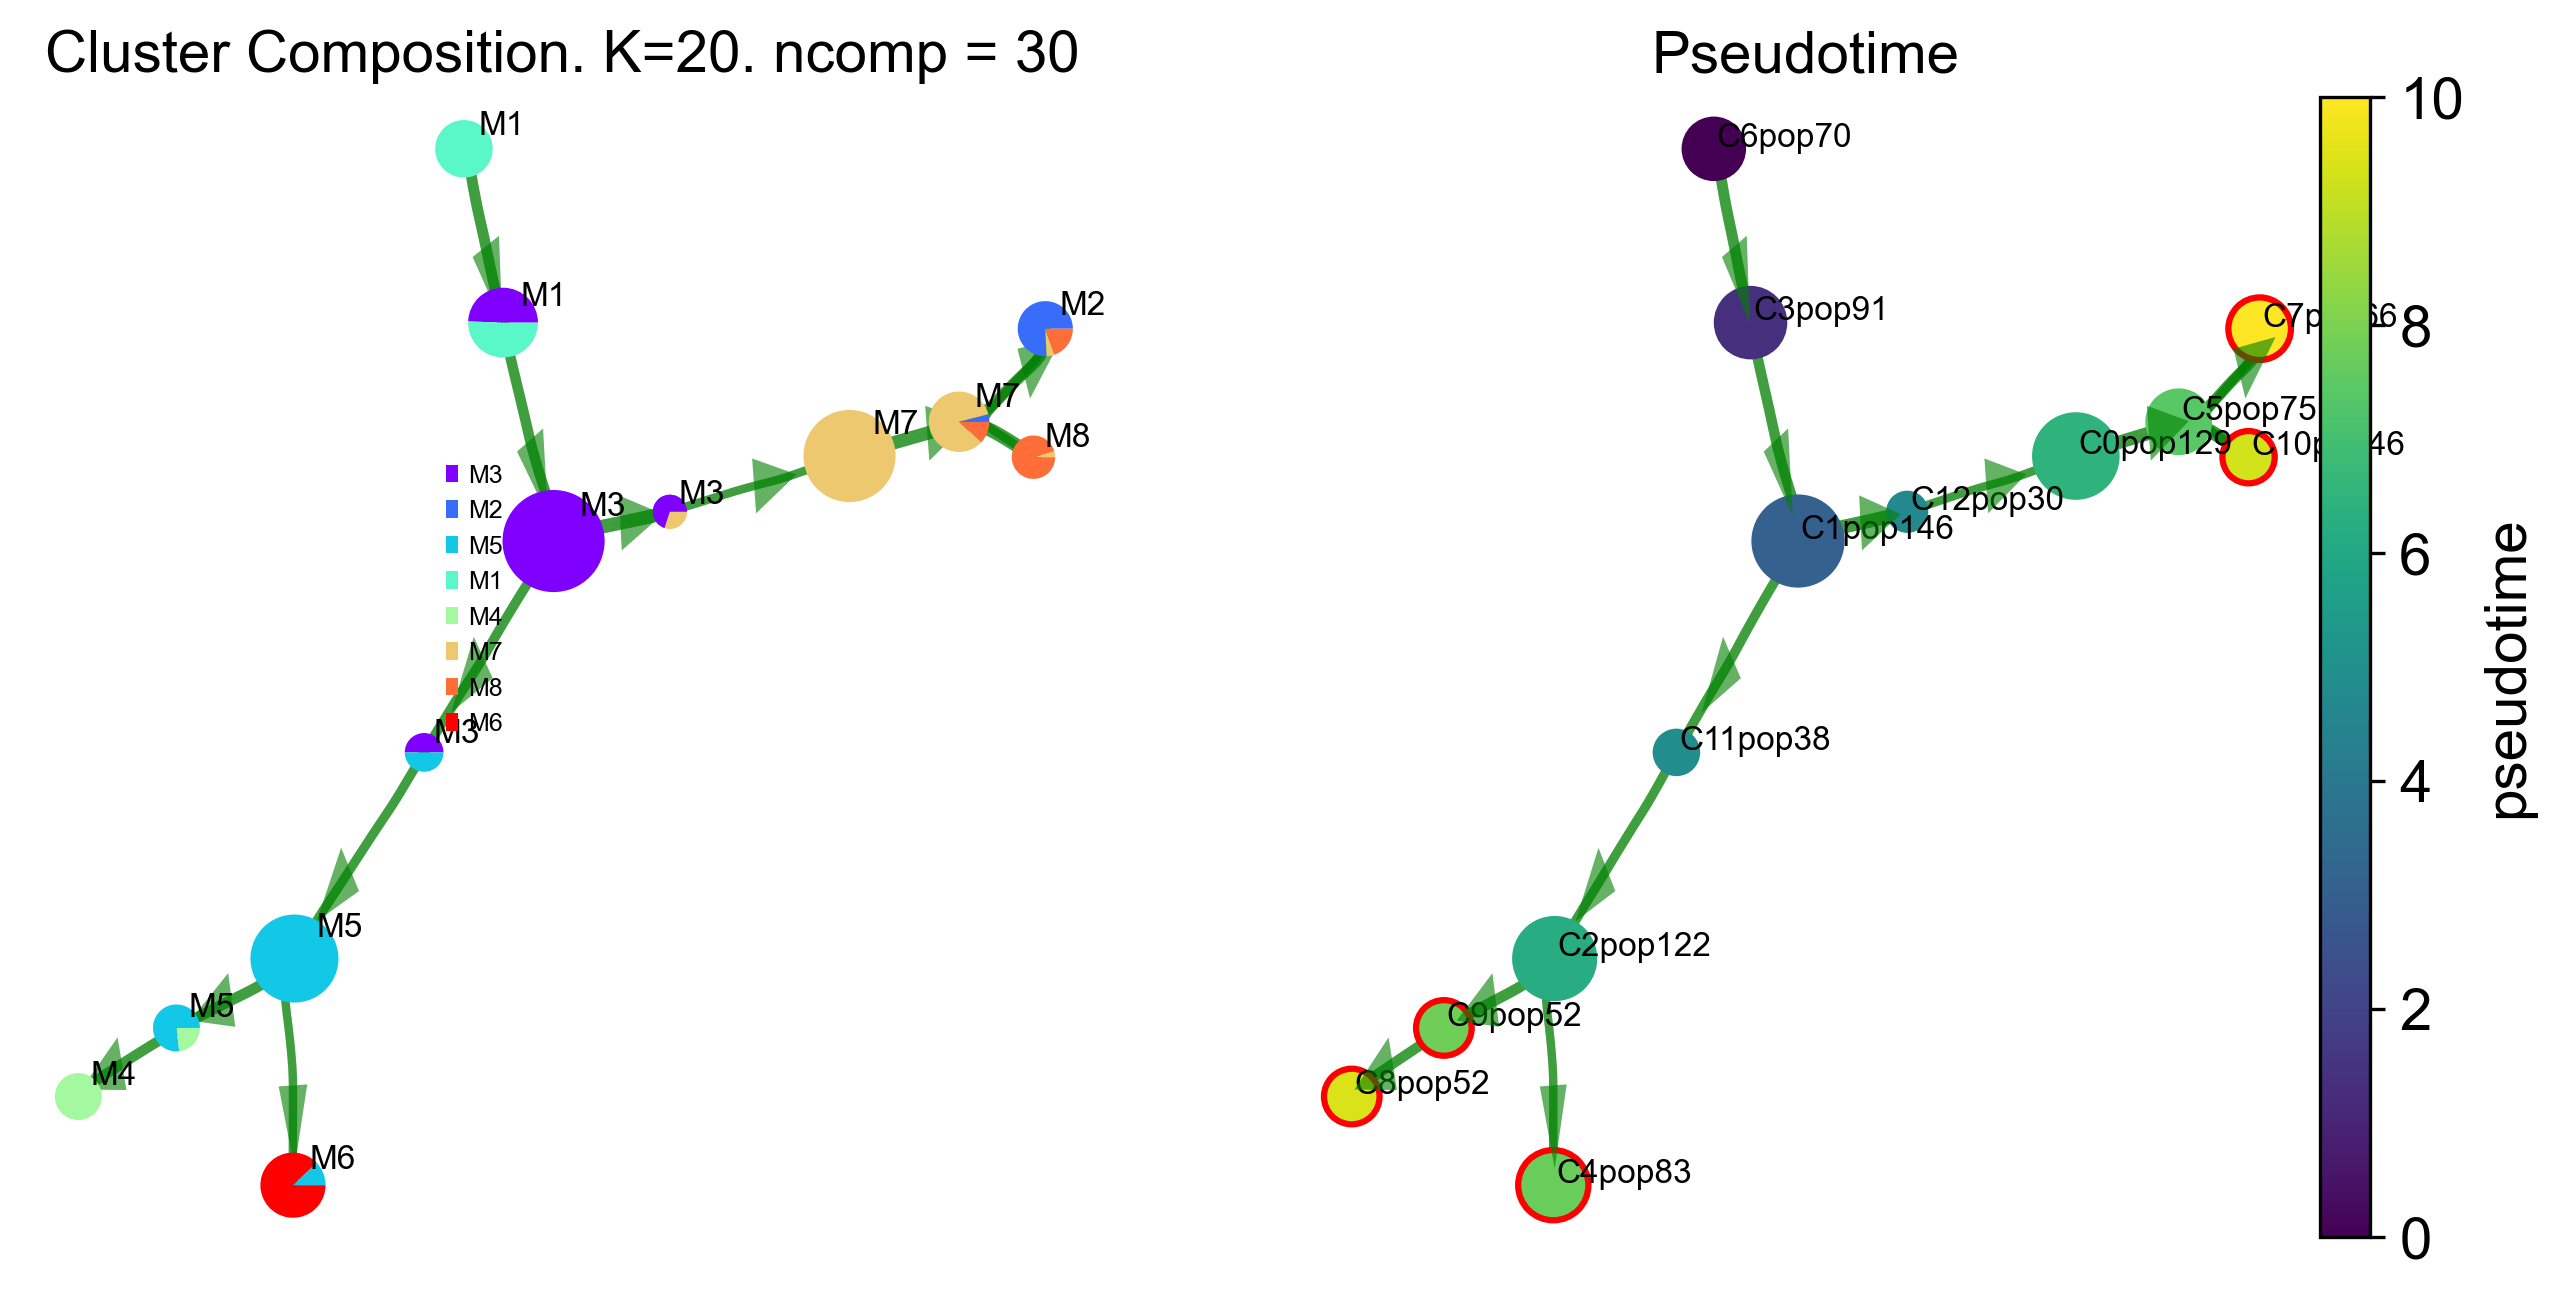

In [4]:
# draw the piechart clustergraph beside a clustergraph colored by the pseudotime ('pt') or gene expression ('gene').
# type_pt: 'pt' automatically takes the cluster level pseudotimes. 'gene' requires user to also pass gene_exp 
# gene_exp =''. In order to plot gene intensity, a list of cluster level gene/feature values should be provided as a list
# cmap = None. Can be specified and influences the cmap of the pt/gene graph
# ax_text = True. Can set to false if you don't want the cluster and populations labels 
# other features like edge width, color, alpha can be set here too
# Terminal lineage clusters have red outline (in rhs graph)
fig, ax, ax2= draw_piechart_graph(via0=v0, type_data='pt', title='Toy multifurcation', cmap='viridis', ax_text=True, gene_exp='', alpha_edge=0.5, linewidth_edge=1.5, edge_color='green', headwidth_arrow=0.2)
fig.set_size_inches(10,5)



## Scatter Plots
#### colored by true_label

No handles with labels found to put in legend.


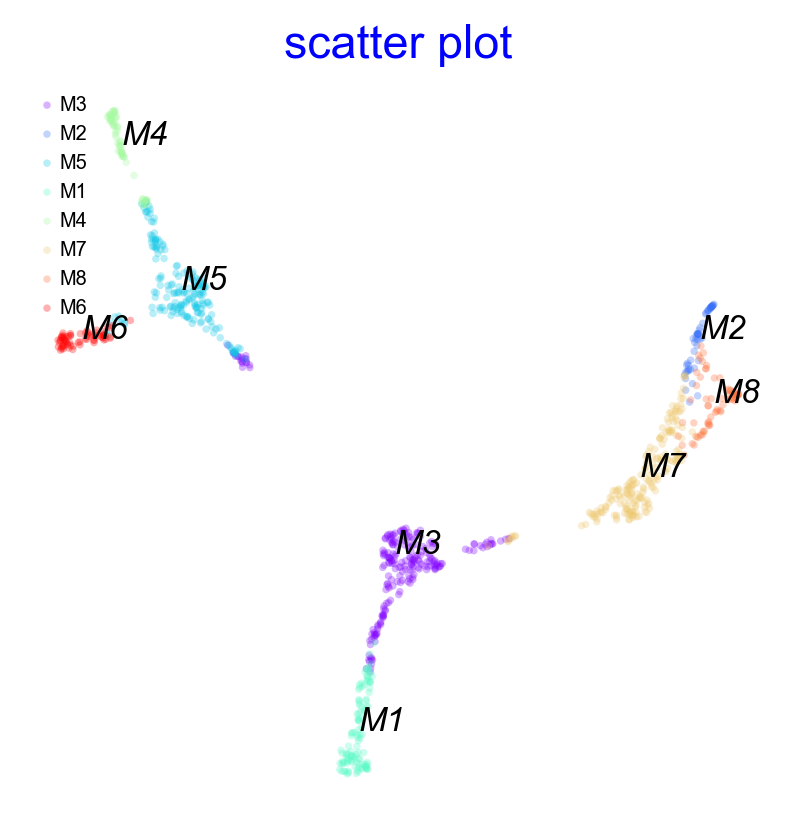

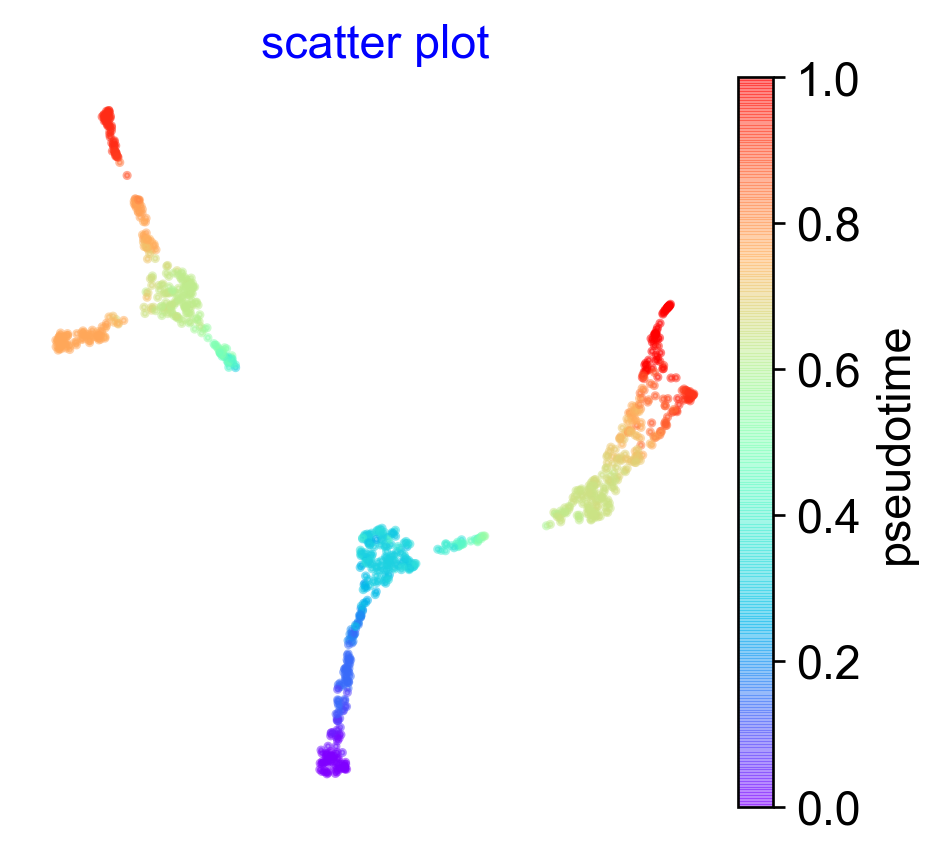

In [5]:
f, ax = plot_scatter(embedding = embedding, labels = v0.true_label)
f, ax = plot_scatter(embedding = embedding, labels = v0.single_cell_pt_markov)

## VIA-mds fast visualization using underlying single-cell VIA-graphs
For automated computation (probably easiest): simply run VIA with do_compute_embedding = True, and embedding_type = 'via-mds'. 
For more control after running VIA, simply call the via_mds() function. When using time-series data consider using via-mds and via-umap automatically for improved visualizations that are well integrated with the Trajectory.
#### Parameters
- n_milestones (default 2000) larger number takes longer time and more RAM
- double_diffusion (default False) setting True can sharpen the "strokes"
- t_diffusion (default 1) higher values can incur more smoothing
- time_series_labels (list of numeric values, length n_samples representing some kind of sequential/temporal information, such as sampling times). 

2023-01-04 14:08:00.289364	Commencing Via-MDS
2023-01-04 14:08:00.289472	Resetting n_milestones to 2000 as n_samples > original n_milestones
2023-01-04 14:08:00.664328	Start computing with diffusion power:1
2023-01-04 14:08:00.679675	Starting MDS on milestone
2023-01-04 14:08:01.895086	End computing mds with diffusion power:1
2023-01-04 14:08:01.938071	Commencing Via-MDS
2023-01-04 14:08:01.938178	Resetting n_milestones to 2000 as n_samples > original n_milestones
2023-01-04 14:08:02.333020	Start computing with diffusion power:1
2023-01-04 14:08:02.347866	Starting MDS on milestone
2023-01-04 14:08:03.502257	End computing mds with diffusion power:1


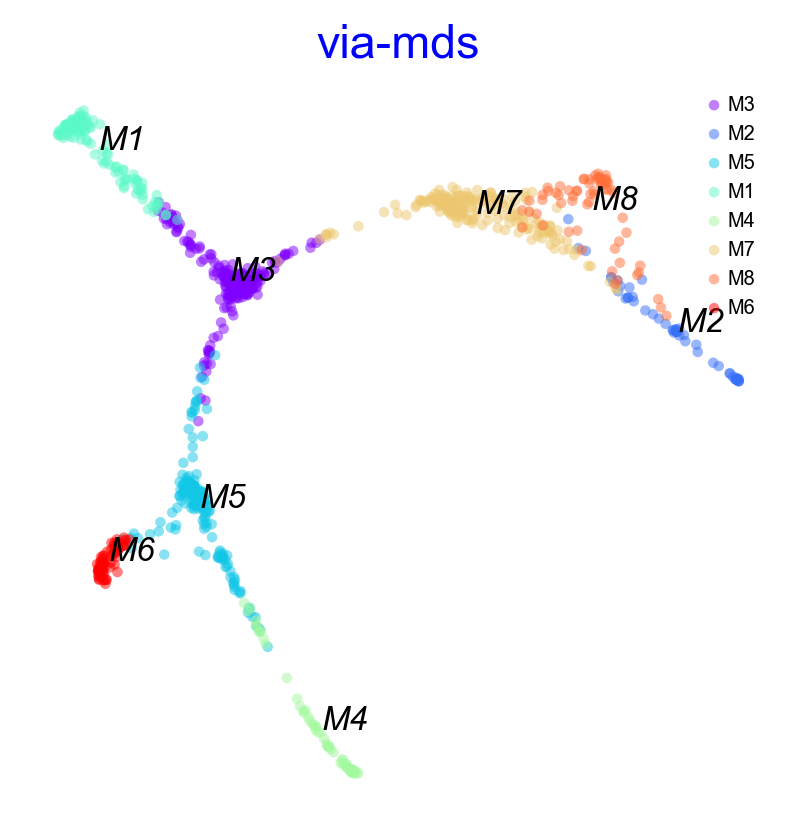

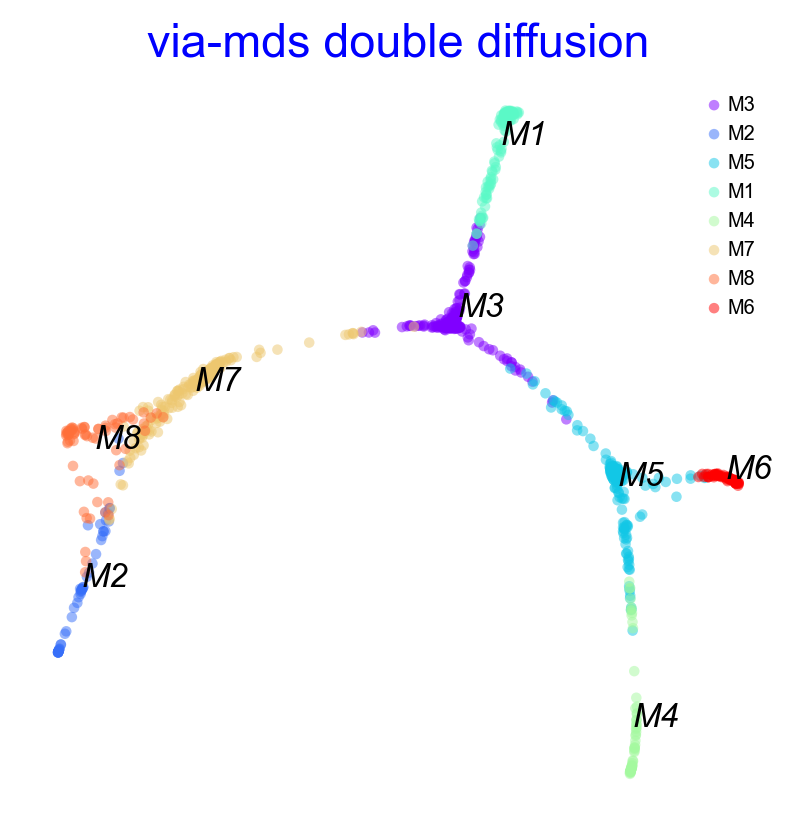

In [6]:
via_mds_embedding1 = via_mds(via_object=v0)
f, ax = plot_scatter(embedding=via_mds_embedding1, labels=v0.true_label, s=10, alpha=0.5, title='via-mds')

via_mds_embedding2 = via_mds(via_object=v0, double_diffusion = True)
f, ax = plot_scatter(embedding=via_mds_embedding2, labels=v0.true_label, s=10, alpha=0.5,title='via-mds double diffusion')

## via-umap based on underlying via scgraphs

2023-01-04 13:40:19.995059	Computing umap on sc-Viagraph
graph.data.size 19000 28.264 38.715
graph.data.size 19000 19000


/home/shobi/anaconda3/envs/Via2Env/lib/python3.7/site-packages/umap/spectral.py:317: RuntimeWarning: divide by zero encountered in true_divide
  1.0 / np.sqrt(diag_data), 0, graph.shape[0], graph.shape[0]


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


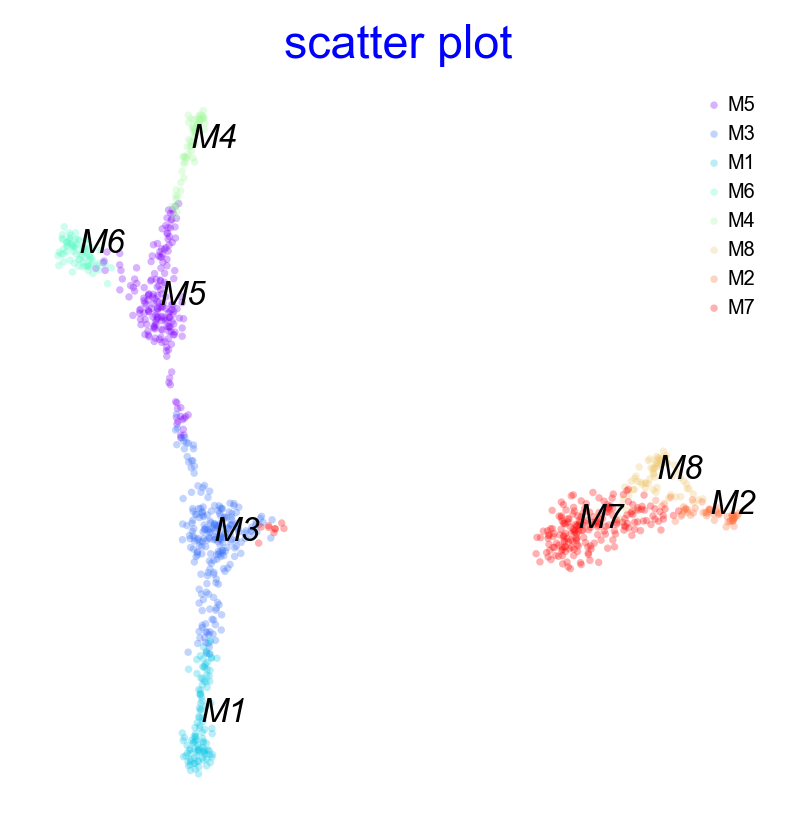

In [26]:
via_umap1 = run_umap_hnsw(X_input=v0.data, graph=v0.csr_full_graph, min_dist=0.2, random_state=42 )
f, ax = plot_scatter(embedding=via_umap1, labels=v0.true_label)

### Vector field
The vector field of trajectories is projected onto the embedding 

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


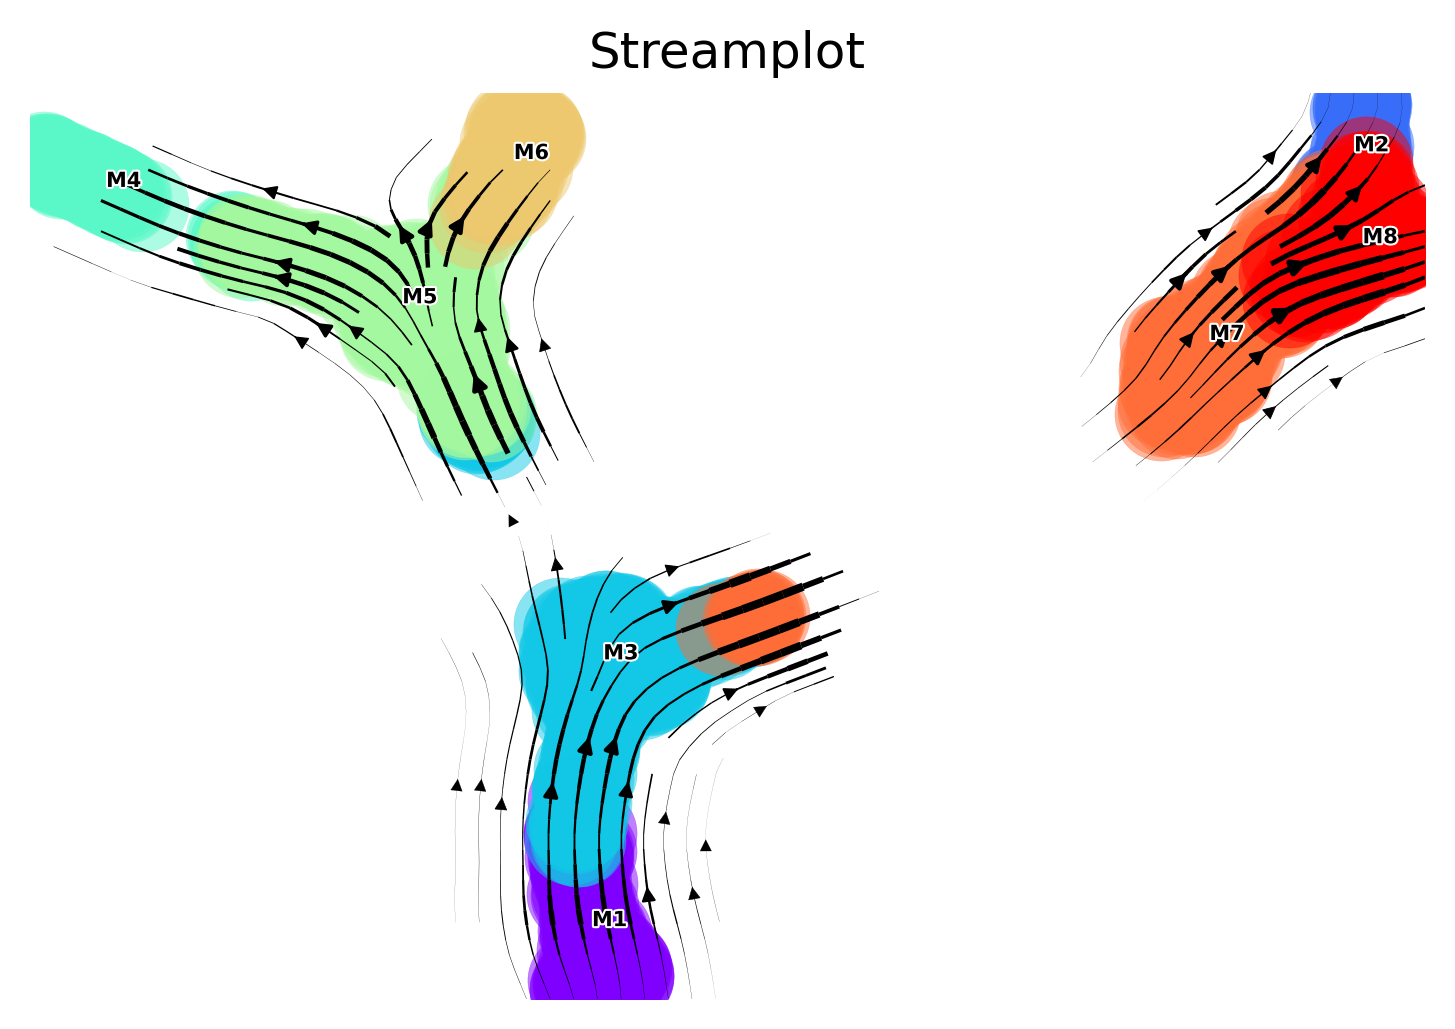

In [9]:
#default parameters:
# scatter_size=500
# scatter_alpha=0.5
# marker_edgewidth=0.1, outline of scatter points
# density_stream = 2, spacing between field lines
# smooth_transition=1,smoothing of transition matrix over neighbors of neighbors
# color_scheme = 'annotation', corresponds to true_labels  (cell types) provided. Can also be set to 'cluster' and 'time' and 'other'
# add_outline_clusters=False
# other_labels = [] provide a list of values for each cell corresponding to the value / annotation you wish to plot

via_streamplot(v0, embedding)

2022-08-24 20:32:55.315504	Inside animated. File will be saved to location /home/shobi/Trajectory/Datasets/Toy3/test_toy3.gif
total number of stream lines 2329


  0%|          | 0/27 [00:00<?, ?it/s]


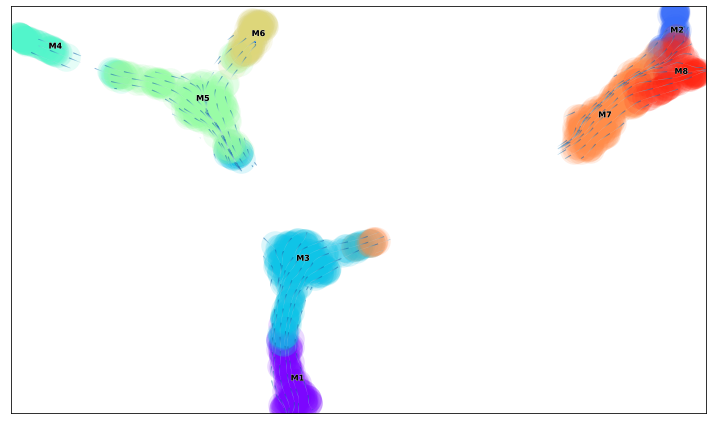

In [10]:
animated_streamplot(v0, embedding, scatter_size=800, scatter_alpha=0.15, density_grid=2,  saveto='/home/shobi/Trajectory/Datasets/Toy3/test_toy3.gif' )

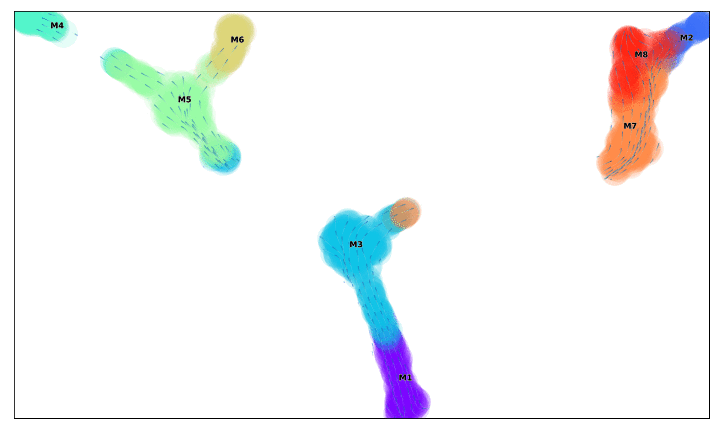

In [15]:
from IPython.display import Image
with open('/home/shobi/Trajectory/Datasets/Toy3/test_toy3.gif','rb') as file:
    display(Image(file.read()))

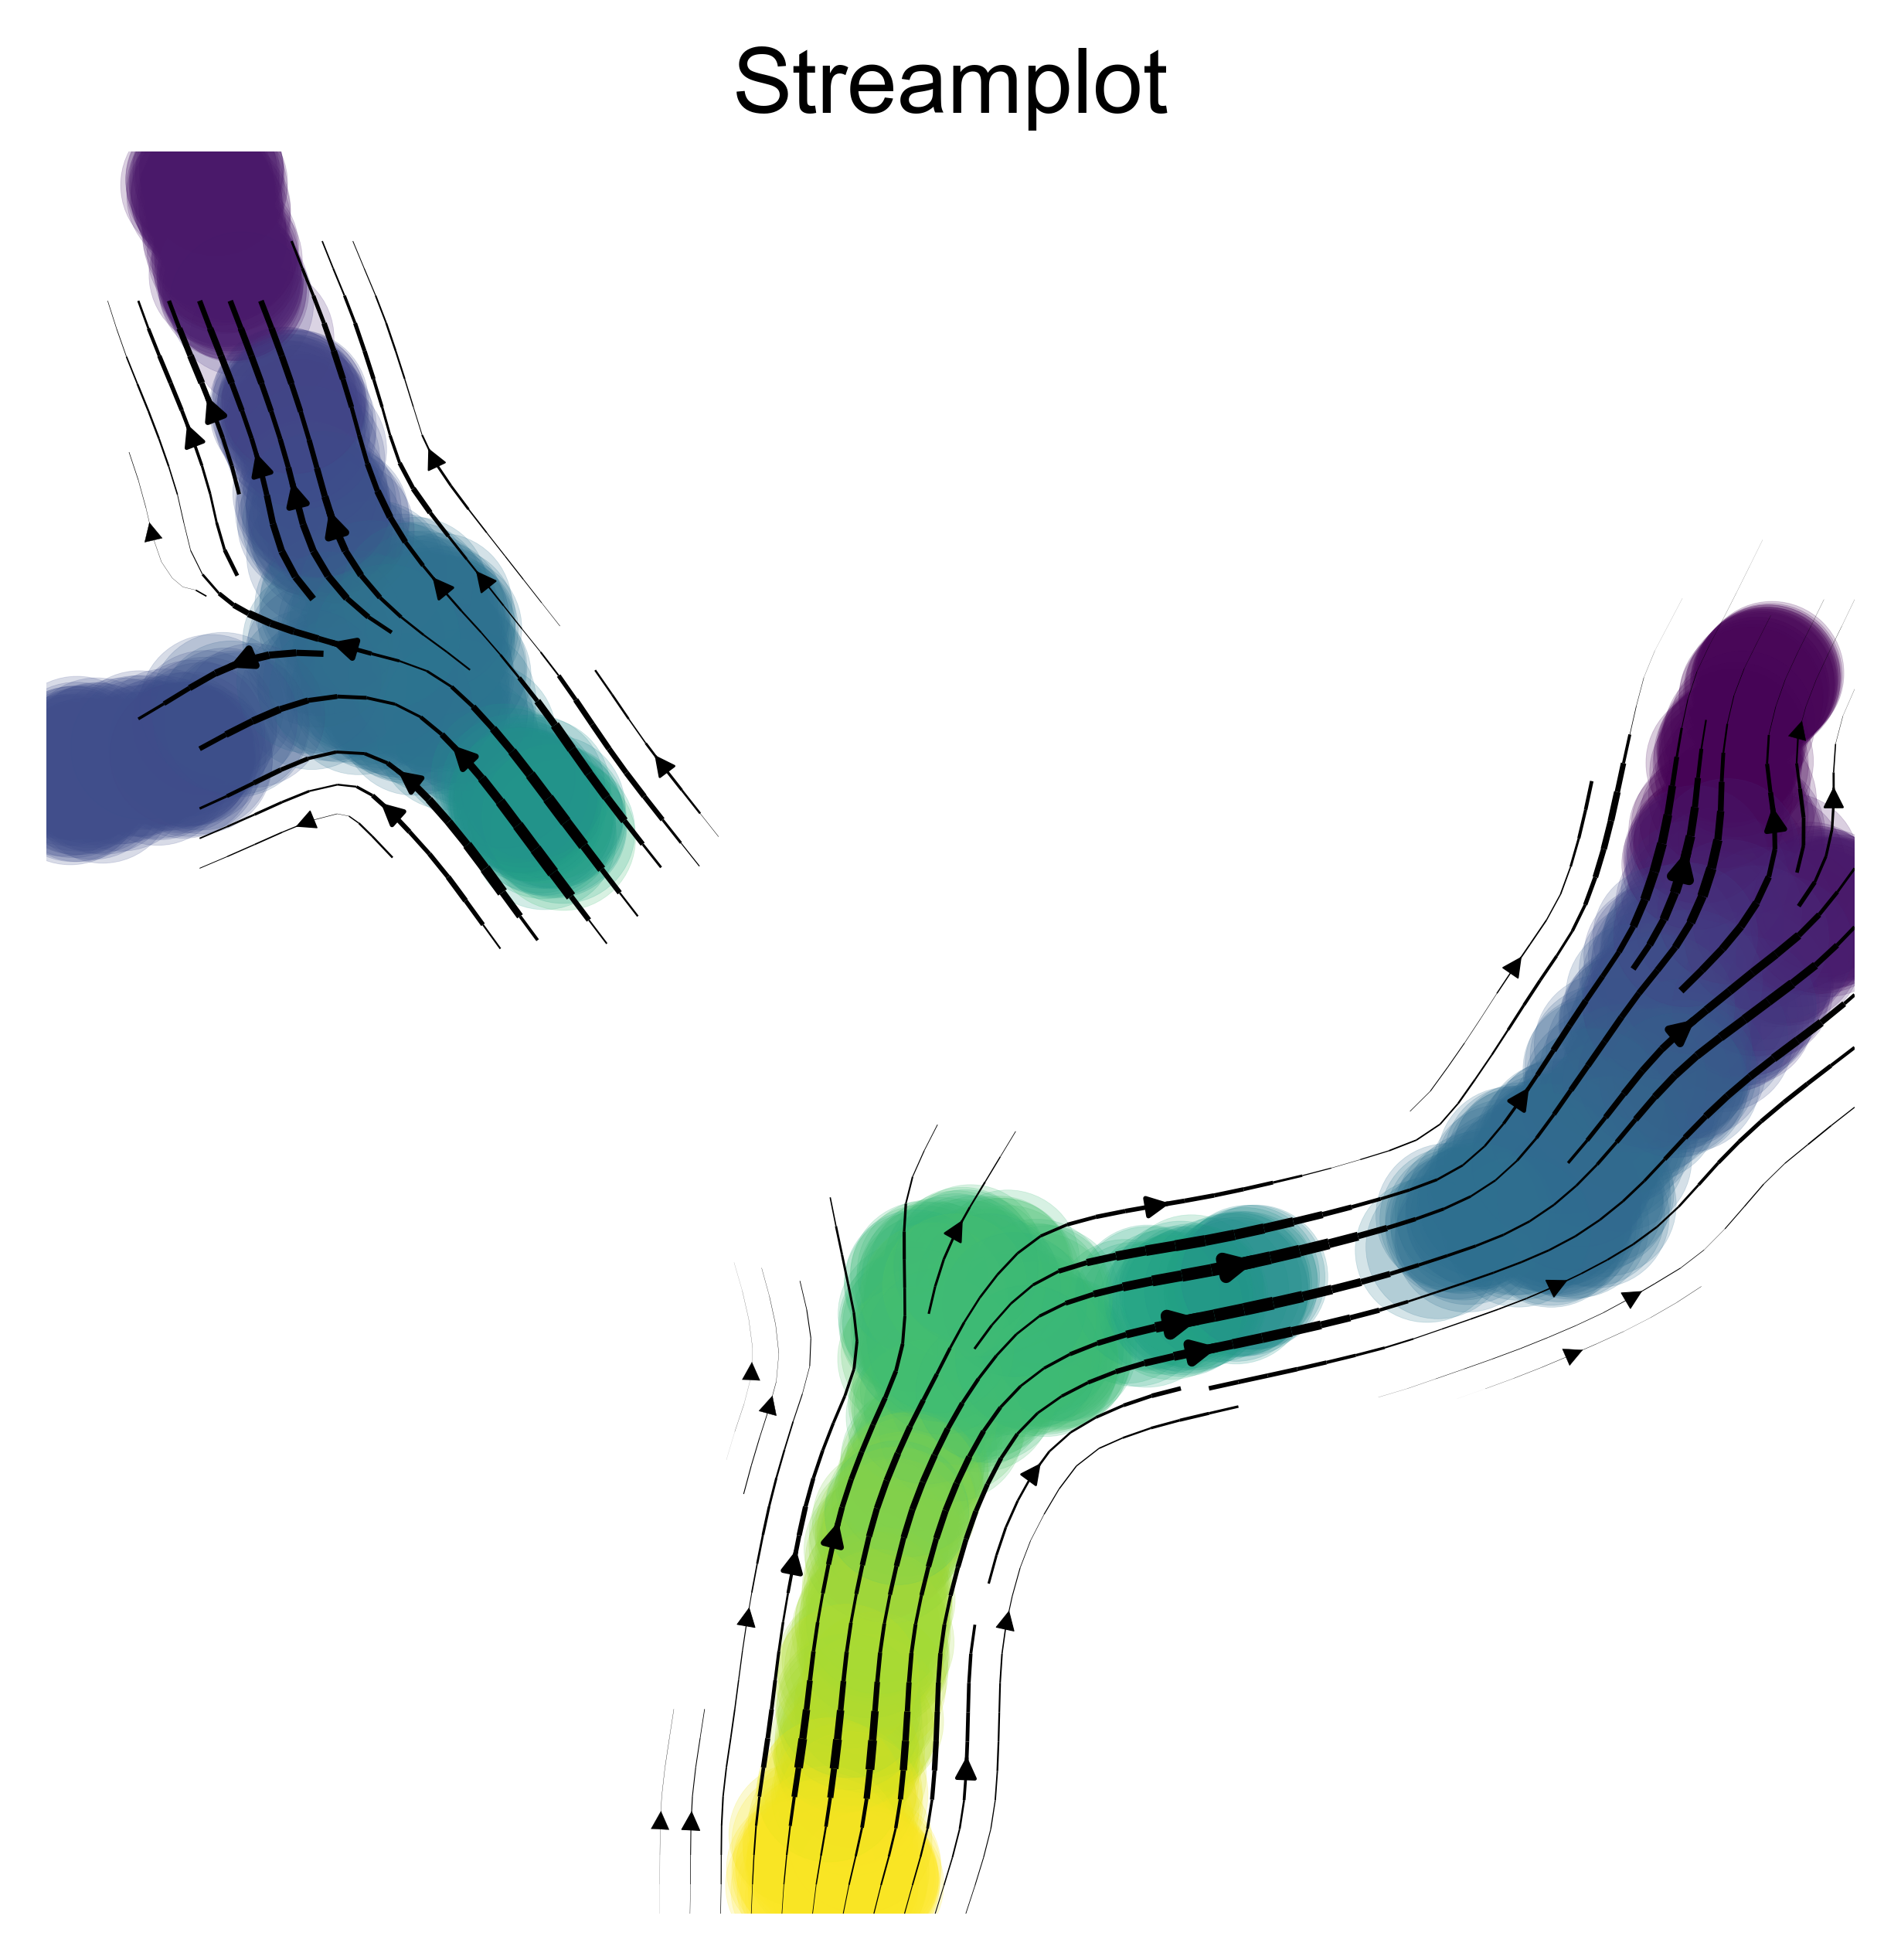

In [13]:
f, ax =via_streamplot(v0, embedding, color_scheme='time',linewidth=1,min_mass = 1, cutoff_perc = 5,scatter_size=500, scatter_alpha=0.2,marker_edgewidth=0.1, density_stream = 2, smooth_transition=1, smooth_grid=.5)# other args: add_outline_clusters=True, cluster_outline_edgewidth =0.005
f.set_size_inches(5,5)

### Overall trajectory 
Draw overall pseudotime and main trajectories on single cell embedding 

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

2022-08-26 13:29:19.041954	Super cluster 4 is a super terminal with sub_terminal cluster 4
2022-08-26 13:29:19.042299	Super cluster 7 is a super terminal with sub_terminal cluster 7
2022-08-26 13:29:19.042495	Super cluster 8 is a super terminal with sub_terminal cluster 8
2022-08-26 13:29:19.042690	Super cluster 9 is a super terminal with sub_terminal cluster 9
2022-08-26 13:29:19.042879	Super cluster 10 is a super terminal with sub_terminal cluster 10


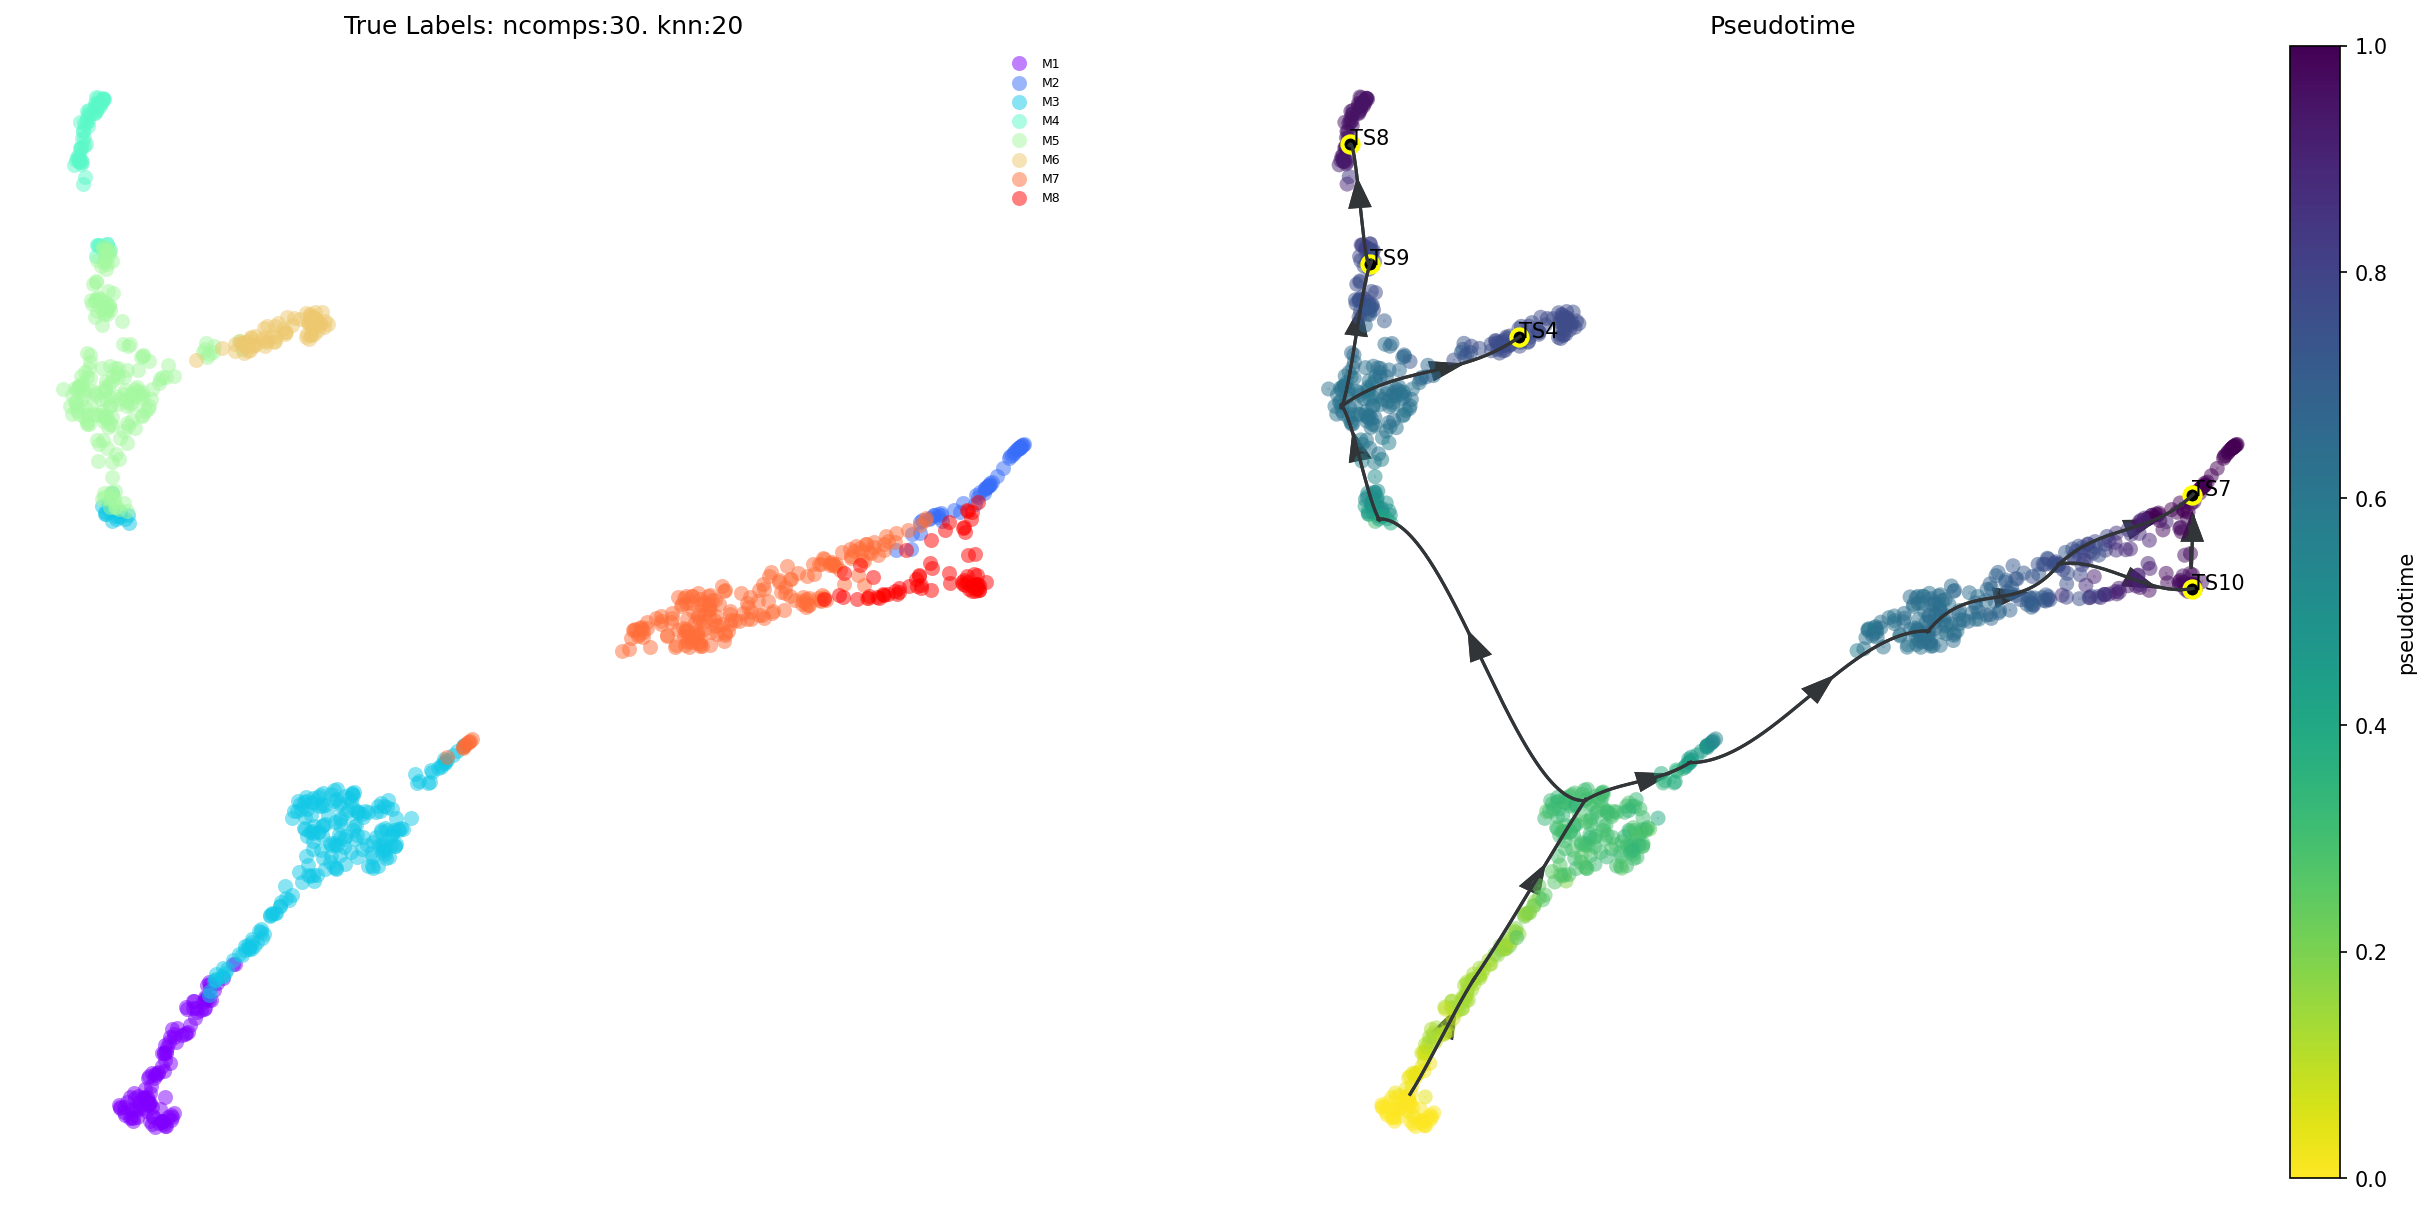

In [11]:
# draw overall pseudotime and main trajectories
draw_trajectory_gams(via_coarse=v0, via_fine=v0, embedding=embedding)
plt.show()

### Lineage probabilities
Plot the lineage probabilities for each lineage (associated with a terminal state)

2023-01-04 14:09:52.083675	Marker_lineages: [4, 7, 8, 9, 10]
2023-01-04 14:09:52.086159	The number of components in the original full graph is 1
2023-01-04 14:09:52.086292	For downstream visualization purposes we are also constructing a low knn-graph 
2023-01-04 14:09:52.471599	Check sc pb [0.444 0.023 0.17  0.339 0.023]
2023-01-04 14:09:52.488504	Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 4: [6, 3, 1, 11, 2, 4]
2023-01-04 14:09:52.488568	Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 7: [6, 3, 1, 12, 0, 5, 7]
2023-01-04 14:09:52.488590	Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 8: [6, 3, 1, 11, 2, 9, 8]
2023-01-04 14:09:52.488608	Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 9: [6, 3, 1, 11, 2, 9]
2023-01-04 14:09:52.488626	Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 10: [6, 3, 1, 12, 0, 5, 10]
2023-01-04 14:09:52.569626

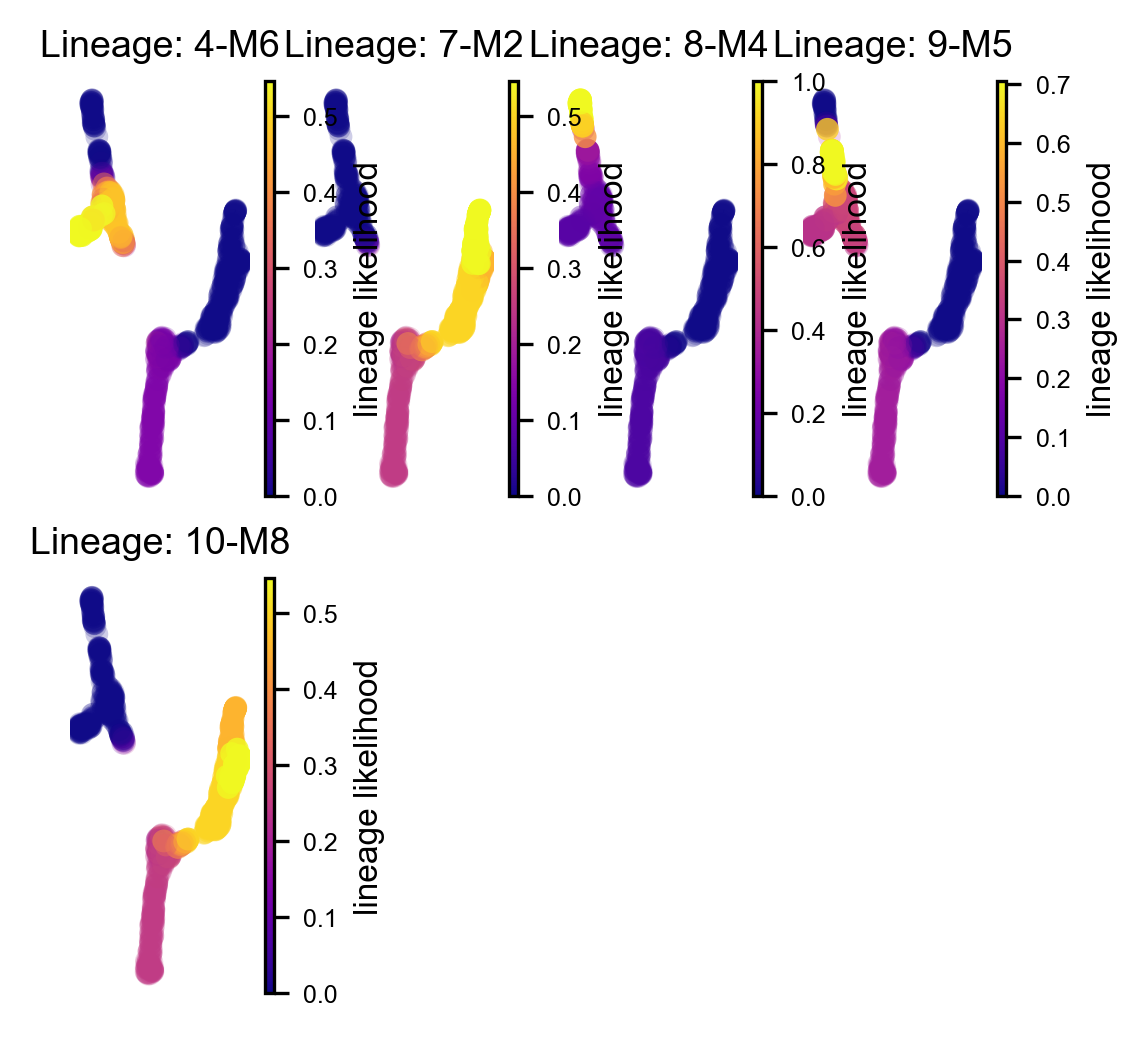

In [14]:
f, axs = draw_sc_lineage_probability(via_coarse=v0, via_fine=v0,embedding=embedding)
plt.show()
f.set_size_inches(15,2)

###  Gene Dynamics
Plot the gene expression levels along each lineage for marker genes. Here we use dummy values for the Genes which are just the values of the initial PCs for illustrative purposes

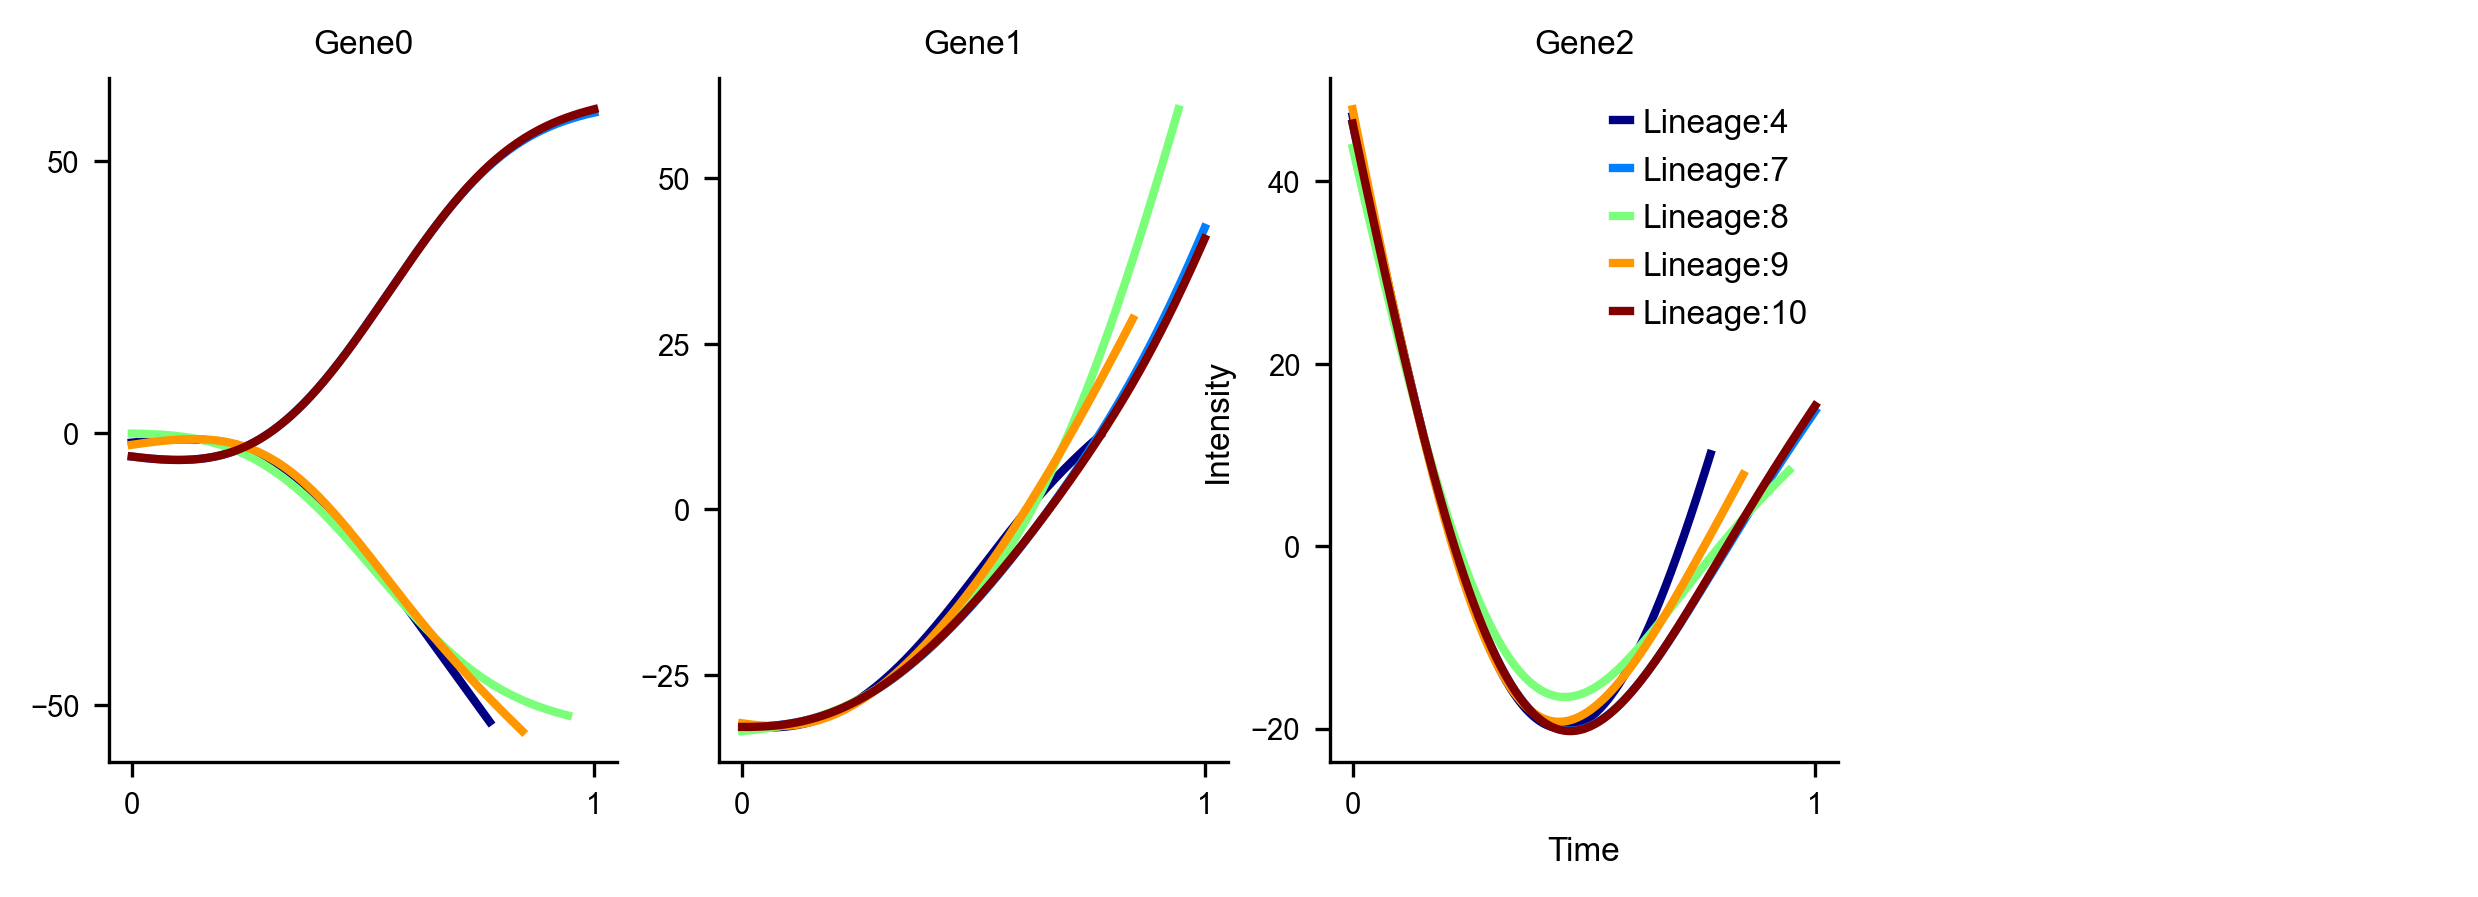

In [19]:
df_subset = pd.DataFrame(adata_counts.obsm['X_pca'][:, 0:3], columns=['Gene0', 'Gene1', 'Gene2'])
f, axs = get_gene_expression(via0=v0, gene_exp=df_subset, cmap='jet',linewidth=2, fontsize_=8, spline_order=4, n_splines=10) #default parameters shown here for retrieving gene expression
f.set_size_inches(10,3)


2023-01-04 14:10:04.294823	Computing Edges
2023-01-04 14:10:04.294963	Start finding milestones
2023-01-04 14:10:04.532937	End milestones
2023-01-04 14:10:04.535116	Recompute weights
2023-01-04 14:10:04.536593	pruning milestone graph based on recomputed weights
2023-01-04 14:10:04.537440	Graph has 1 connected components before pruning
2023-01-04 14:10:04.537773	Graph has 1 connected components before pruning
2023-01-04 14:10:04.539159	Graph has 1 connected components after reconnecting
2023-01-04 14:10:04.539443	regenerate igraph on pruned edges
2023-01-04 14:10:04.542241	Setting numeric label as time_series_labels or other sequential metadata for coloring edges
2023-01-04 14:10:04.547717	Making smooth edges


/home/shobi/anaconda3/envs/Via2Env/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


2023-01-04 14:10:04.869189	Finished plot
2023-01-04 14:10:04.869670	Computing Edges
2023-01-04 14:10:04.869720	Start finding milestones
2023-01-04 14:10:05.063724	End milestones
2023-01-04 14:10:05.065711	Recompute weights
2023-01-04 14:10:05.070088	pruning milestone graph based on recomputed weights
2023-01-04 14:10:05.071322	Graph has 1 connected components before pruning
2023-01-04 14:10:05.074591	Graph has 1 connected components before pruning
2023-01-04 14:10:05.075264	regenerate igraph on pruned edges
2023-01-04 14:10:05.078047	Setting numeric label as time_series_labels or other sequential metadata for coloring edges
2023-01-04 14:10:05.082761	Making smooth edges
2023-01-04 14:10:05.654121	Finished plot


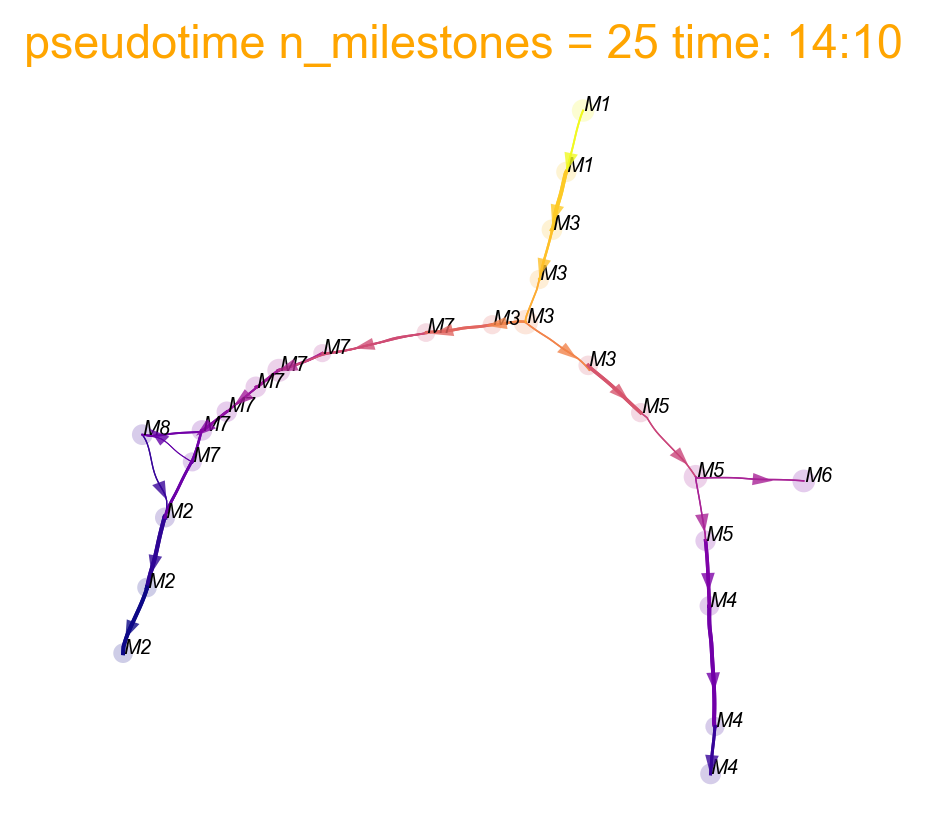

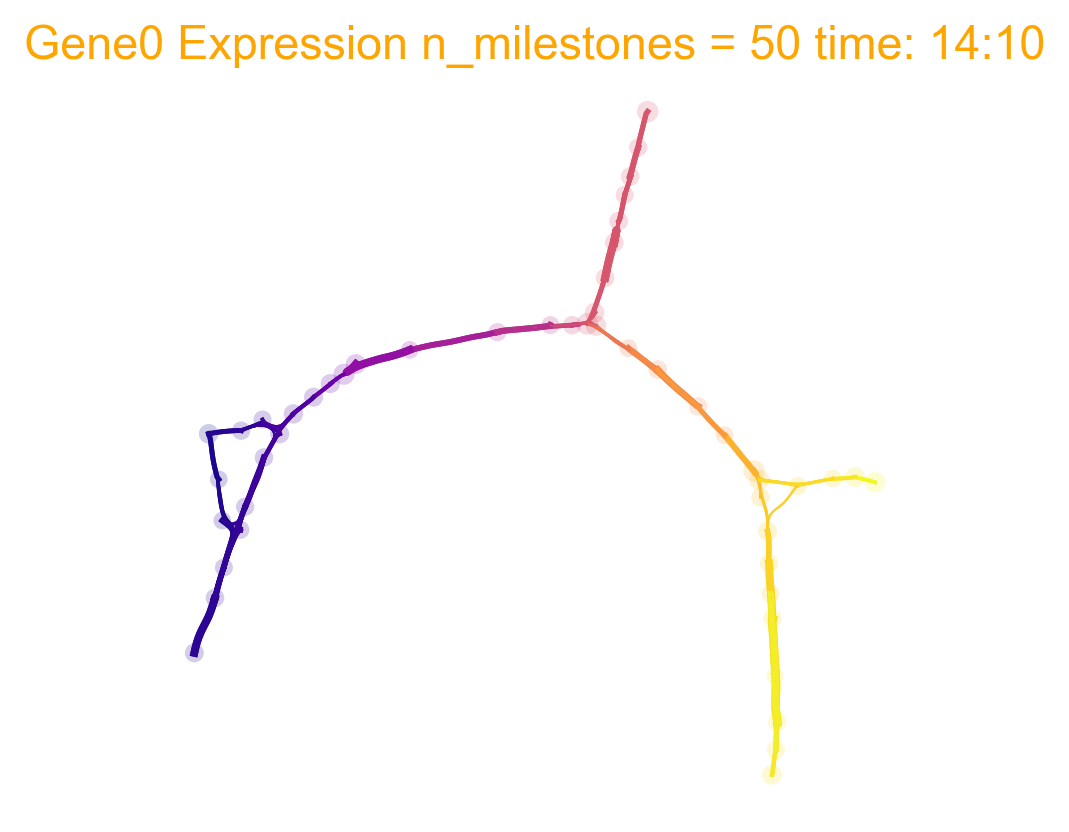

In [15]:
v0.embedding = via_mds_embedding2
f,ax = plot_edge_bundle(via_object=v0, n_milestones=25, linewidth_bundle=0.5, alpha_bundle_factor=2,
                     cmap='plasma_r', facecolor='white', size_scatter=15, alpha_scatter=0.2, scale_scatter_size_pop=True,
                     extra_title_text='pseudotime', headwidth_bundle=2.5, text_labels=True, sc_labels=true_label)
f,ax = plot_edge_bundle(via_object=v0, n_milestones=50, linewidth_bundle=1.5, alpha_bundle_factor=2,
                     cmap='plasma_r', facecolor='white', size_scatter=15, alpha_scatter=0.2, scale_scatter_size_pop=True,
                     extra_title_text='Gene0 Expression', headwidth_bundle=0.5, sc_labels_expression = adata_counts.obsm['X_pca'][:, 0].tolist(), text_labels=False, sc_labels=true_label)

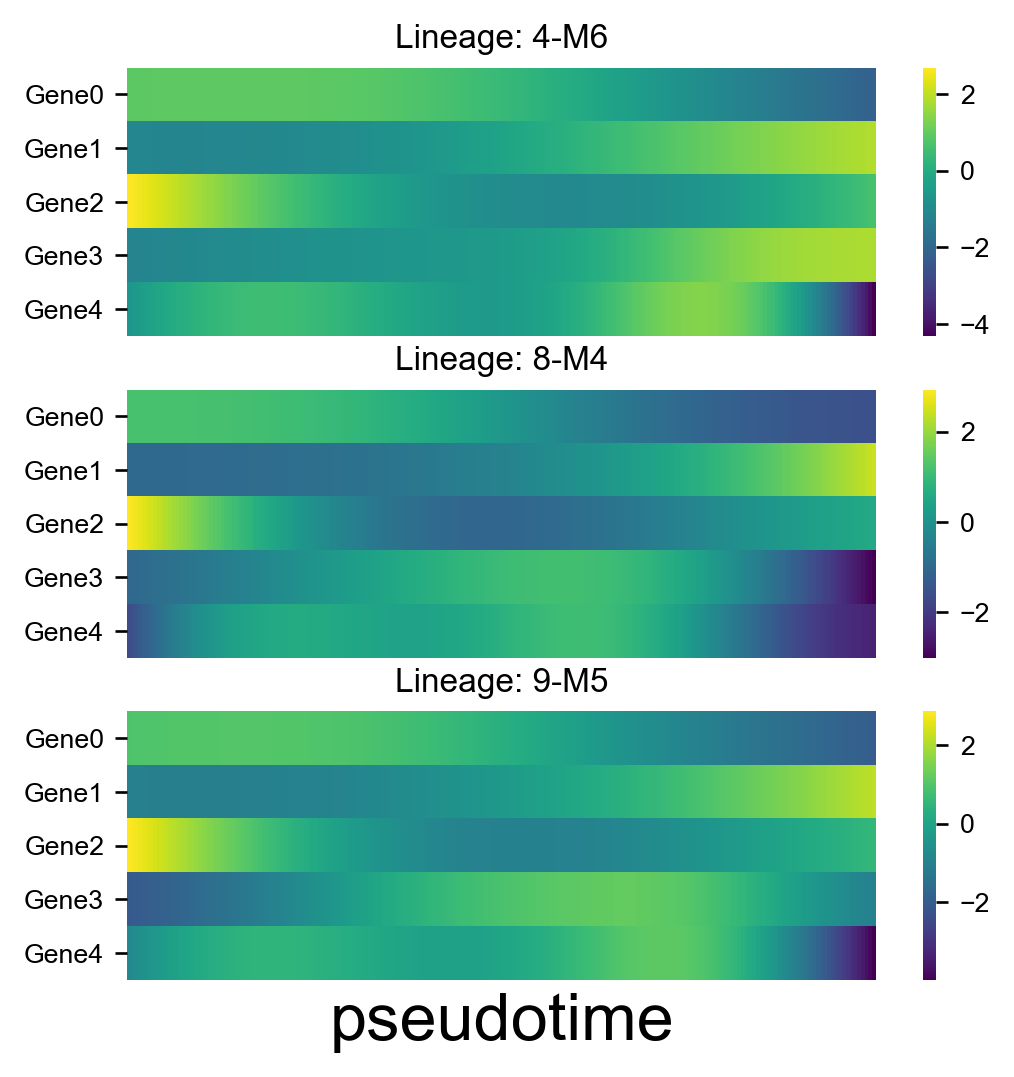

In [17]:
df_genes = pd.DataFrame(adata_counts.obsm['X_pca'][:, 0:5], columns=['Gene0', 'Gene1', 'Gene2', 'Gene3', 'Gene4'])

f, axlist = plot_gene_trend_heatmaps(via_object=v0, df_gene_exp=df_genes, marker_lineages=[4,8,9])
axlist[-1].set_xlabel("pseudotime", fontsize=20)
f.set_size_inches(5,5)